<h1>Computer Vision and Image Processing</h1>
<h2>Fruit Inspection - First Task</h2>
<h4>Gabriele Marconi<br/>Daniele Ceccarelli</h4>


In this document we will develop an <b>Image Processing routine</b> that solves the first task of
<a href="./fruit-inspection.pdf">this project</a> for every image given:
<ul>
    <li><a href="./asset/first_task/C1_000001.png">Image 01</a></li>
    <li><a href="./asset/first_task/C1_000002.png">Image 02</a></li>
    <li><a href="./asset/first_task/C1_000003.png">Image 03</a></li>
</ul>

<b>NIR</b> versions of the same images are also provided:
<ul>
    <li><a href="./asset/first_task/C0_000001.png">NIR Image 01</a></li>
    <li><a href="./asset/first_task/C0_000002.png">NIR Image 02</a></li>
    <li><a href="./asset/first_task/C0_000003.png">NIR Image 03</a></li>
</ul>

The objectives are:
<ol>
    <li>Outline the fruit by generating a <b>binary mask</b>.</li>
    <li>Search for the <b>defects</b> on each fruit.</li>
</ol>
It is advised to <b><i>Run All</i></b> the scripts before reading the document, for a better understanding of the report.
<br/><br/>
The code begins by importing all of the necessary packages.

In [17]:
import cv2
from cv2 import pointPolygonTest
import numpy as np
from matplotlib import pyplot as plt
from enum import Enum

<b><i>Choose the image.</i></b>

In [18]:
class Image_num(Enum):
    IMG1=1
    IMG2=2
    IMG3=3

IMAGE = Image_num.IMG1

We also import both the colored image and the NIR image using <b>OpenCV</b>.<br/>
Then, we make a copy of the colored image that will be used to show the final results.

In [19]:
IMAGE = str(IMAGE.value)

image=cv2.imread("./asset/first_task/C0_00000"+IMAGE+".png",cv2.IMREAD_GRAYSCALE)
img = cv2.imread("./asset/first_task/C1_00000"+IMAGE+".png")
final_img=img.copy()
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

./asset/first_task/C0_000001.png


<h3>Generating a Binary Mask</h3>

All the operations are done using the grayscale NIR image and the results will be shown on the colored image.<br/>
Firstly, we threshold the image using <b>Adaptive Thresholding</b> as the background is clearly distinguishable from the fruit and a binary image is easier to work with.<br/>
The normal <b>Thresholding</b> was not used so that the resulting binary image stays more consistent even with other images.

The result has very strong lines where the grayscale values differ the most, however it also shows a lot of noise, especially inside the fruit.<br/>
We can fix this by using the <b>Open</b> operator.

This <a href="https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html">Morphological Transformation</a> reduces noise (small white points) in a binary image.<br/><br/>
<b><i>The function parameters were determined empirically.</i></b>

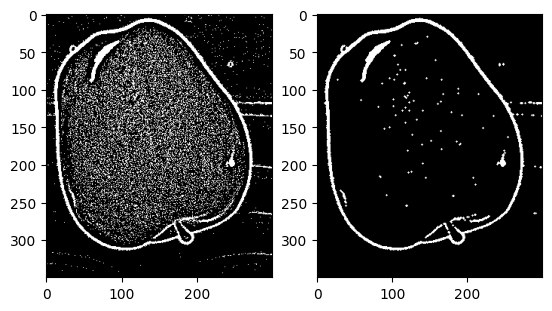

In [20]:
t_image=cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)

kernel_opcl=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
open=cv2.morphologyEx(t_image,cv2.MORPH_OPEN,kernel_opcl)


f, axarr = plt.subplots(1,2)
axarr[0].imshow(t_image,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(open,cmap='gray',vmin=0, vmax=255)
plt.show()

We now have to isolate the shape of the fruit to create a working mask.<br/>
OpenCV's <a href="https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html">Contours</a> can help with that.<br/>
They are described as "<i>...a curve joining all the continuous points (along the boundary), having same color or intensity.</i>".<br/>

This can satisfy our needs as the <i>findContours</i> function finds all contours in an image and returns them in an array as a set of coordinates.<br/>
Then, we sort the list based on the <b>size of the area</b> included in the contour by using the <i>contourArea</i> function.

In our case, following all the operations above, the biggest area will always be the one that contains the entire fruit, as the contour that follows the fruit's external edges is always present. 

Then, we select this contour (which now is the first in the list) and draw it onto a blank image. By specifying the -1 flag (called <b>thickness</b>) in the <i>drawContours</i> function, the contour will be filled with color.

<b>The result is our mask</b>.

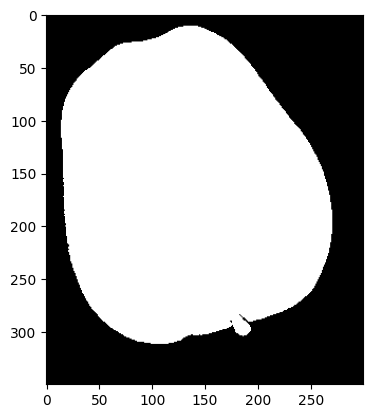

In [21]:
contours,hier=cv2.findContours(open,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

blank=np.zeros(image.shape,np.uint8)
contours=list(contours)
contours.sort(key=cv2.contourArea,reverse=True)
cv2.drawContours(blank,contours,1,(255,255,255),-1)

plt.imshow(blank,cmap='gray',vmin=0, vmax=255)
plt.show()

We now apply the mask and show the result.

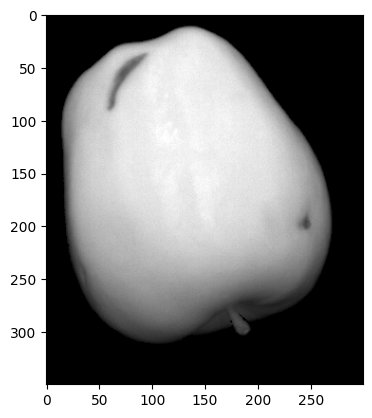

In [22]:
mask = blank.copy()

masked=cv2.bitwise_and(image,image,mask=mask)

plt.imshow(masked, cmap='gray',vmin=0, vmax=255)
plt.show()

<h3>Searching for the Defects</h3>

In the next step, we begin the isolation of the <b>defects</b>.<br/><br/>

The inside of the fruit in the NIR image has very clear contrast between the defects and the healthy surface.<br/>
So, to highlight the defects, we can use <b>edge detection</b> algorithms.<br/><br/>

In the first place, we use some <b>Gaussian Blur</b> to make surfaces more uniform and avoid unwanted edges.<br/>
Then, the <a href="https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html">Canny Edge Detection</a> algorithm is used.<br/><br/>

<b><i>The function paramenters were determined empirically.</i></b>

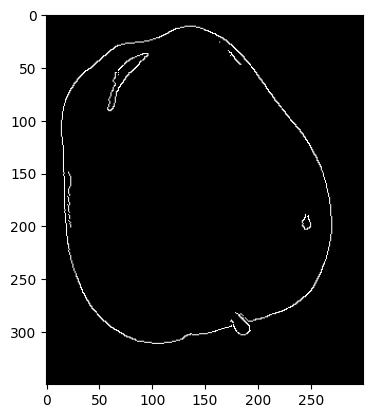

In [23]:
img_blur = cv2.GaussianBlur(masked, (3,3), 0)
edges = cv2.Canny(image=masked, threshold1=70, threshold2=130)
plt.imshow(edges, cmap='gray',vmin=0, vmax=255)
plt.show()

To make lines more consistent, we use the <b>dilate</b> operator.

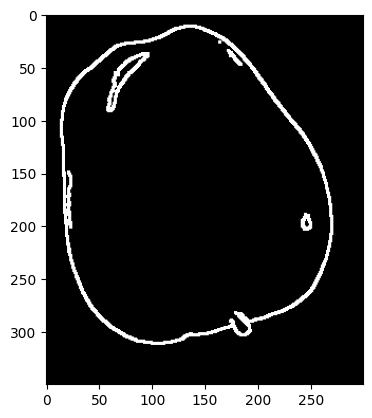

In [24]:
kernel_dil=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilated=cv2.dilate(edges,kernel_dil,iterations=1)

plt.imshow(dilated, cmap='gray',vmin=0, vmax=255)
plt.show()

The next step is to find all contours in the <b>dilated edges image</b> and delete the contour relative to the external boundary of the fruit.<br/>
However, after the <b>dilation</b>, all countours are doubled as the algorithm detects the external and internal contours of every white line.<br/>
<br/>
So, after sorting the contours by area size, we have to delete the <b>first 2 contours</b>, not just the first.

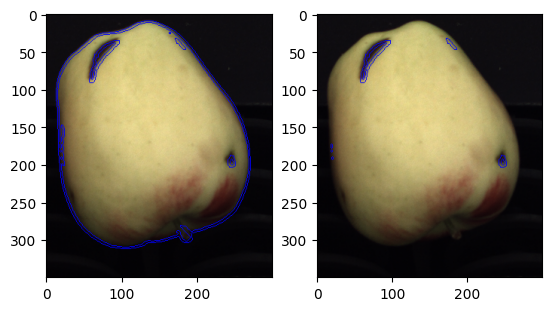

In [25]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
temp_img = img.copy()

contours_edge,hier_edge=cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(temp_img,contours_edge,-1,(0,0,255),1)  # Draw all the contours

contours_edge=list(contours_edge)
contours_edge.sort(key=cv2.contourArea,reverse=True)
contours_edge = contours_edge[2:]   # Delete first two contours

cv2.drawContours(img,contours_edge,-1,(0,0,255),1)  # Draw all contours except fruit boundary

f, axarr = plt.subplots(1,2)
axarr[0].imshow(temp_img,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(img,cmap='gray',vmin=0, vmax=255)
plt.show()

To isolate the defects we have to filter the newly found contours.<br/>
For the sake of this, a few observations and assumptions have been made:
<ul>
    <li>All the photos have been taken at a <b>constant distance</b> from the base under the fruit.</li>
    <li>All fruits are apples, so we assume a conversation with the company in which we can obtain the <b>minimum dimensions</b><br/>
    of the fruit itself and of the defects. </li>
</ul><br/>
We have used the following criteria in the filtering process:
<ol>
    <li>
        <b>Filled contours filtering</b>: All the true defects in the binary images obtained in the last step consistently have black space inside them,<br/> so we delete all contours that contain mostly white pixels.<br/>
        As an example we consider the second image:<br/><br/>
        <img src="./resources/filled_contours_example.png" alt="Girl in a jacket" width="250" height="270"><br/><br/>
        <span>The <b>stem</b> is not a defect and it doesn't have black pixels inside so it won't be considered.</span>
    </li>
    <br/>
    <li><b>Small contours filtering</b>: The <b>size</b> of the contour area (or, in this case, the defect area) is another important aspect of filtering.<br/>
    If a contour is too small (based on the conversation with the company), it is not going to be considered.<br/>
    This particular form of filtering has a lot of overlap with the <b>Filled contours filtering</b>, as most of the small contours are also completely white.<br/> Still, we thought it would be important to consider all possibilities.</li>
</ol>

In [26]:
filtered_contours = []
for idx, contour in enumerate(contours_edge):
    blank = np.zeros(image.shape, dtype='uint8')
    cv2.drawContours(blank,contours_edge,idx,(255,255,255),-1)

    locs = np.where(blank == 255)
    pixels = dilated[locs]

    if (np.mean(pixels) < 240 and (cv2.contourArea(contour)>=126.0)):
        filtered_contours.append(contour)

At this point, we should be left only with contours that are <b>inside</b> or <b>on the edge</b> of the defects.<br/><br/>

<img src="./resources/defect_contour_example.png" alt="Girl in a jacket" width="250" height="250"><br/><br/>

Our objective now is to highlight just the edges of the defect, making the resulting image as clear as possible.<br/>
Unfortunately, because of all the previuos operations, the inside of some defects is full of <b>impurities/nested contours</b>, making it harder <br/>
to isolate the external edge.<br/>

By using the <a href="https://docs.opencv.org/3.4/dc/d48/tutorial_point_polygon_test.html">pointPolygonTest</a> function, we are able to distinguish nested contours from the external ones.<br/>

While looping couples of our remaining contours, if one of the two is inside the other, its <i>position</i> in the array gets flagged and, in a later moment, it gets excluded from the final array.<br/>
What we end up with is a list of all the <b>external edges</b> of all the true defects.

In [27]:
inside=np.zeros(len(filtered_contours), np.uint8)
for i, c in enumerate(filtered_contours):
    for j, k in enumerate(filtered_contours):
        if (i!=j):
            if(pointPolygonTest(k,(int(c[0][0][0]),int(c[0][0][1])), False)>=0):
                inside[i]=1

defects=[]
for i,v in enumerate(inside):
    if(v==0):
        defects.append(filtered_contours[i])

Finally, we draw these contours on our initial colored image to show the result.

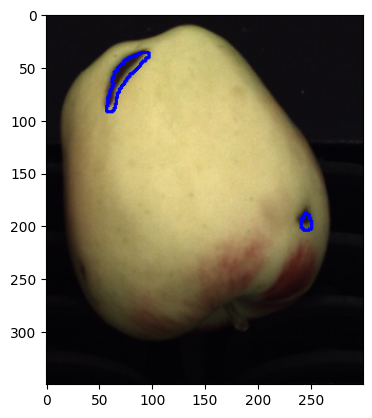

In [28]:
cv2.drawContours(final_img,defects,-1,(0,0,255),2)

plt.imshow(final_img,vmin=0, vmax=255)
plt.show()